## Вычислительный эксперимент

<Figure size 1300x1300 with 0 Axes>

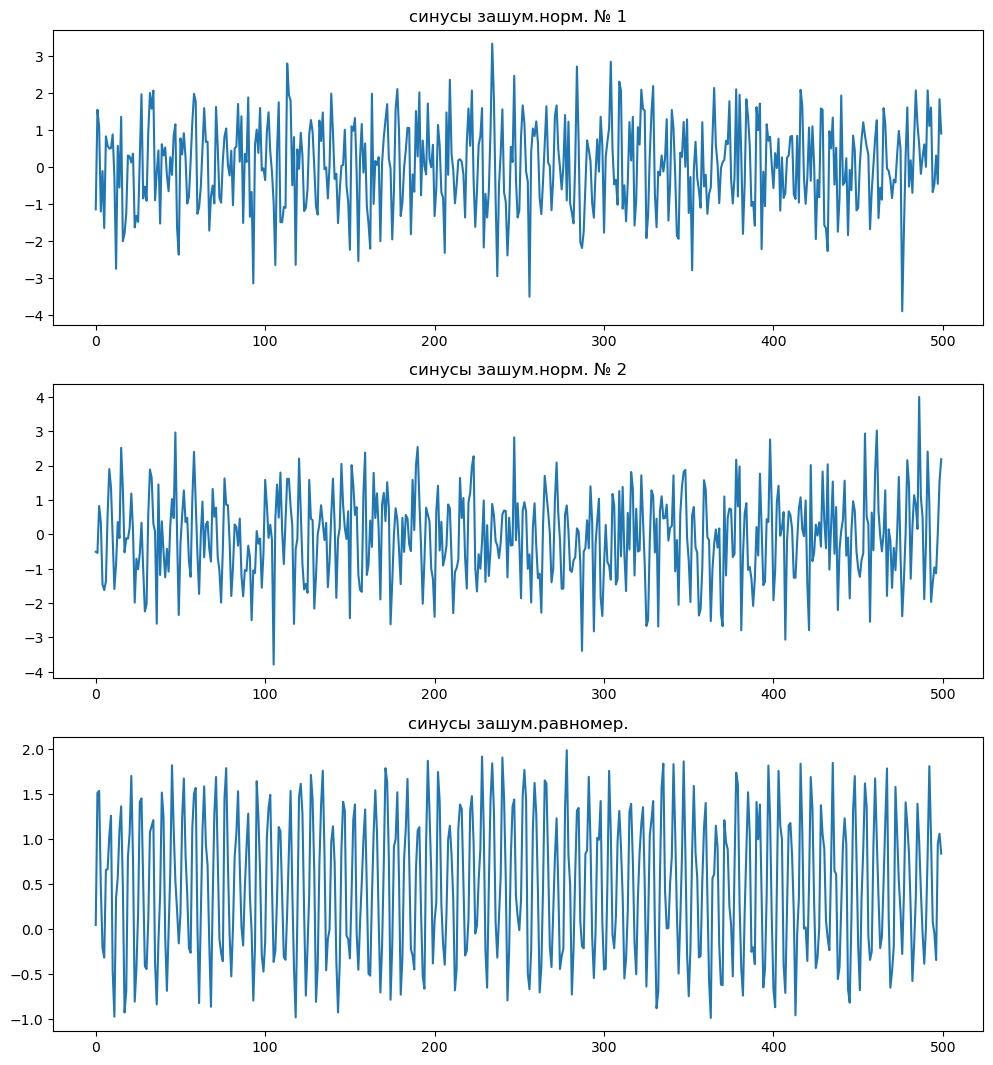

In [23]:
import numpy as np
import matplotlib.pyplot as plt

N = 500
samples = np.array([np.arange(N) + i for i in range(N)],dtype=float)

sinuses = np.sin(samples) # синусы

plt.figure(figsize = [13, 13])

randoms = np.array([np.random.normal(loc = 0, scale = 1) for i in range(1, N + 1)], dtype=float) # зашумляем нормальным распределением


X = sinuses[0] + randoms
Y = sinuses[0] + np.random.normal(loc=0, scale=1, size=N)
Z = sinuses[0] + np.random.uniform(low=0, high=1, size=N)

plt.figure(figsize=[12, 13])

plt.subplot(3, 1, 1)
plt.title('синусы зашум.норм. № 1')
plt.plot(samples[0], X, label = 'синусы зашум.норм.')

plt.subplot(3, 1, 2)
plt.title('синусы зашум.норм. № 2')
plt.plot(samples[0], Y, label = 'синусы зашум.норм.')

plt.subplot(3, 1, 3)
plt.title('синусы зашум.равномер.')
plt.plot(samples[0], Z, label = 'синусы зашум.равномер.')

## Подключение библиотек

In [24]:
import torch
from torch import nn
import statsmodels.api as sm

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

%matplotlib inline
import matplotlib.pyplot as plt

import torchsde

## Настройка модели

In [25]:
import statsmodels.api as sm

brownian_size = 1

class SDE(torch.nn.Module):
    noise_type = 'general'
    sde_type = 'stratonovich'

    def __init__(self, original):
        super().__init__()
        self.sigma = torch.nn.Linear(state_size, state_size * brownian_size)
        self.orig = original
        self.diffs = np.array([self.orig[i] - self.orig[i + 1] for i in range(0, N - 1)]) # разницы элементов временного ряда - так оцениваем производную
        
    # Drift
    def f(self, t, y):
        return torch.from_numpy(np.interp(y.numpy(), self.orig[:N-1], self.diffs)).to(torch.float32) 
        # дрифт - это интерполяционная функция, по значению временного ряда возвращающая производную в этой точке 

    # Diffusion
    def g(self, t, y):
        return self.sigma(y).view(batch_size, state_size, brownian_size) # диффузия определяется рандомно(пока что)

## Прогноз

In [26]:
def get_predict_SDE(values):
    batch_size, state_size, t_size = 12, 1, len(values) # 12 прогнозов одномерного временного ряда из N элементов

# почему нельзя делать слишком много прогнозов(не 100 скажем, а 12)? потому что, когда мы будем строить доверительный интервал и соотвественно оценивать пороги 
# значений вр.ряда сверху и снизу квантилями мы будем стабильно получать постепенно расширяющуюся воронку из-за закона повторного логарифма
# именно так, ведь модель neural sde завязана на винеровском процессе, границы которого асимптотически стремятся к оценкам из него
# чтобы не получать такой бесполезный прогноз - следует брать малое количество предсказаний
    
    sde = SDE(values)
    ts = torch.linspace(0, t_size, t_size) # разметка временного диапазона
    y0 = torch.full(size=(batch_size, state_size), fill_value=values[0]) # начальная точка временного ряда
    
    with torch.no_grad():
        ys = torchsde.sdeint(sde, y0, ts, method='euler_heun')  # (t_size, batch_size, state_size) = (100, 3, 1).

    ts = ts.cpu()
    ys = ys.squeeze().t().cpu()

    avg = np.array([sample.numpy() for i, sample in enumerate(ys)], dtype=float) # распаковываем полученные аппроксимации

    avg_1  = np.quantile(avg, 0.75, axis=0) # диапазоны довер.интервалов
    avg_2  = np.quantile(avg, 0.25, axis=0)

    return avg, avg_1, avg_2

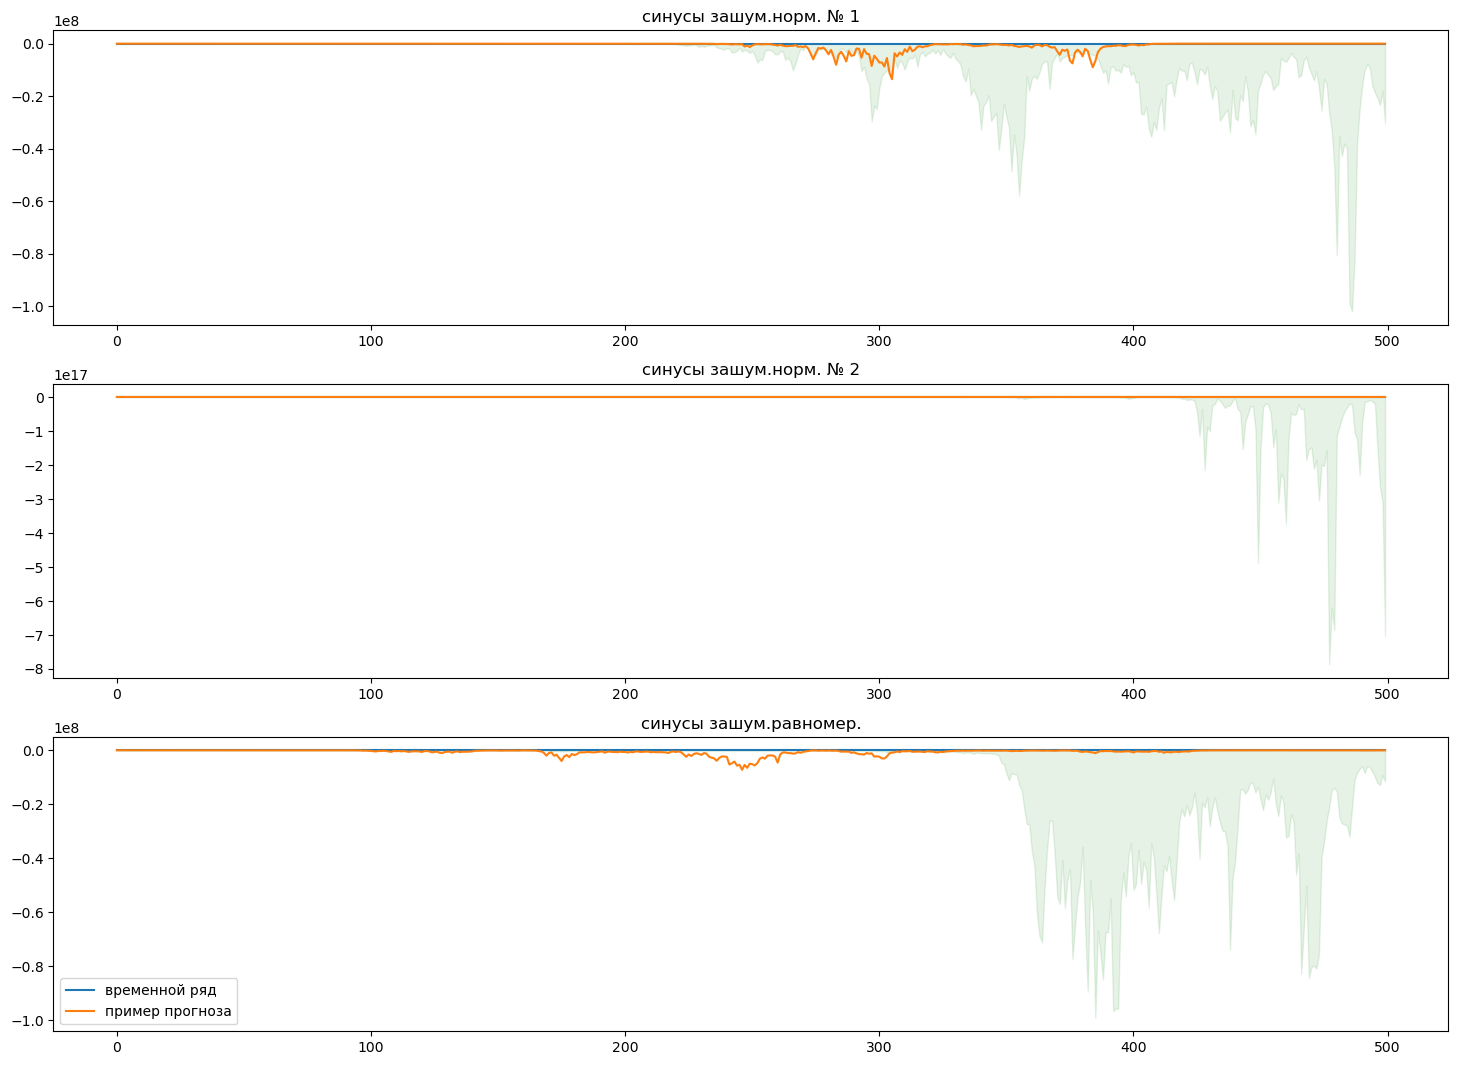

In [28]:
forecast_X, X_down, X_top = get_predict_SDE(X)
forecast_Y, Y_down, Y_top = get_predict_SDE(Y)
forecast_Z, Z_down, Z_top = get_predict_SDE(Z)

plt.figure(figsize=[18, 13])

plt.subplot(3, 1, 1)
plt.title('синусы зашум.норм. № 1')
plt.fill_between(np.arange(N), X_down, X_top, color='green',alpha=0.1)
plt.plot(np.arange(N), X, label='временной ряд')
plt.plot(np.arange(N), forecast_X[0], label='пример прогноза')


plt.subplot(3, 1, 2)
plt.title('синусы зашум.норм. № 2')
plt.fill_between(np.arange(N), Y_down, Y_top, color='green',alpha=0.1)
plt.plot(np.arange(N), Y, label='временной ряд')
plt.plot(np.arange(N), forecast_Y[0], label='пример прогноза')


plt.subplot(3, 1, 3)
plt.title('синусы зашум.равномер.')
plt.fill_between(np.arange(N), Z_down, Z_top, color='green',alpha=0.1)
plt.plot(np.arange(N), Z, label='временной ряд')
plt.plot(np.arange(N), forecast_Z[0], label='пример прогноза')


plt.legend()

plt.show()

## Фазовые траектории

In [34]:
from numpy import diff

dx = 1

phase_trajectories_X = np.array([diff(forecast_X[i]) for i in range(len(forecast_X))])
phase_trajectories_Y = np.array([diff(forecast_Y[i]) for i in range(len(forecast_X))])
phase_trajectories_Z = np.array([diff(forecast_Z[i]) for i in range(len(forecast_X))])


#for i in range(len(forecast_X)):
#    forecast_X[i] = diff(forecast_X[i])/dx
#    forecast_Y[i] = diff(forecast_Y[i])/dx
#    forecast_Z[i] = diff(forecast_Z[i])/dx

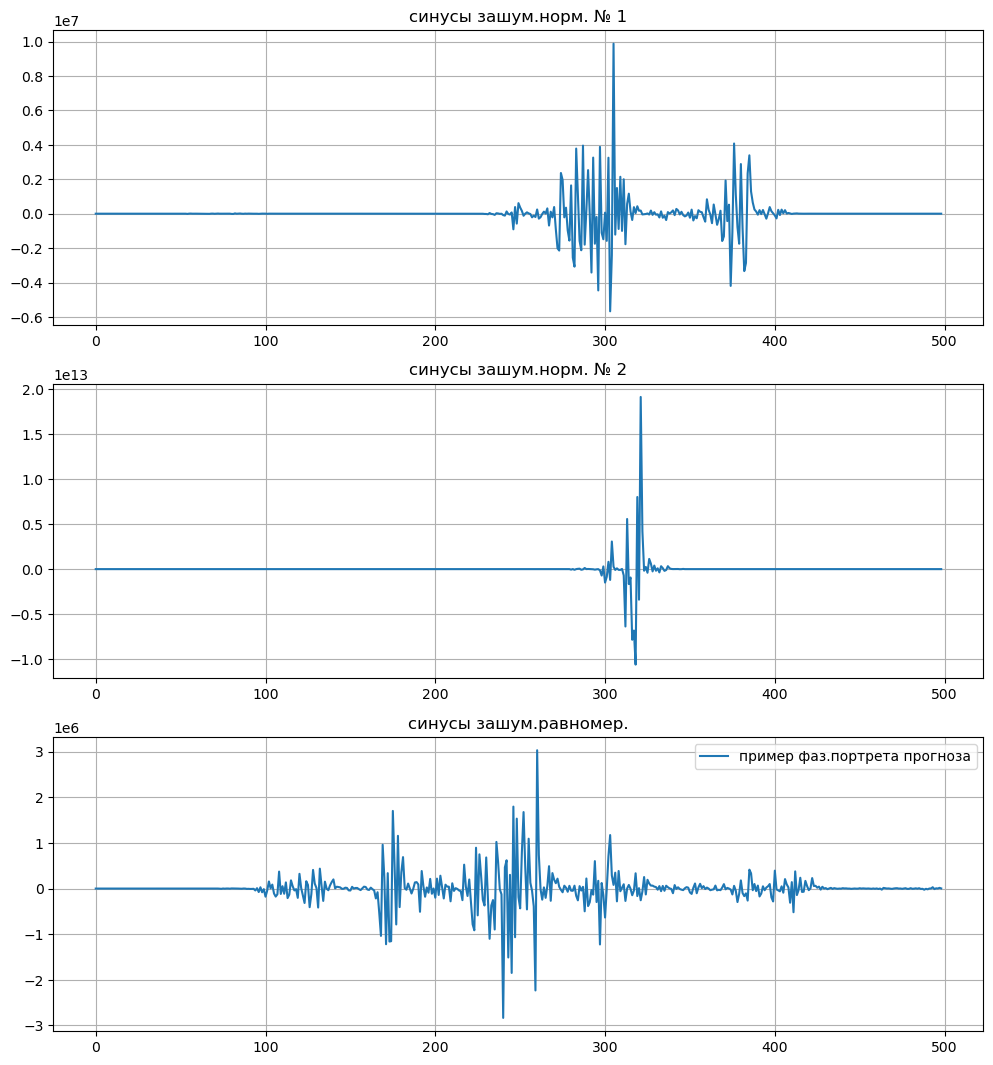

In [42]:
from numpy import diff

dx = 1
plt.figure(figsize=[12, 13])

plt.subplot(3, 1, 1)
plt.title('синусы зашум.норм. № 1')
plt.plot(np.arange(N - 1), phase_trajectories_X[0], label='пример траектории прогноза')
plt.grid()


plt.subplot(3, 1, 2)
plt.title('синусы зашум.норм. № 2')
plt.plot(np.arange(N - 1), phase_trajectories_Y[0], label='пример траектории прогноза')
plt.grid()


plt.subplot(3, 1, 3)
plt.title('синусы зашум.равномер.')
plt.plot(np.arange(N - 1), phase_trajectories_Z[0], label='пример фаз.портрета прогноза')
plt.grid()


#phase_tr_orig = diff(not_offset)/dx ну может пригодится - пока не буду убирать
plt.legend()

plt.show()

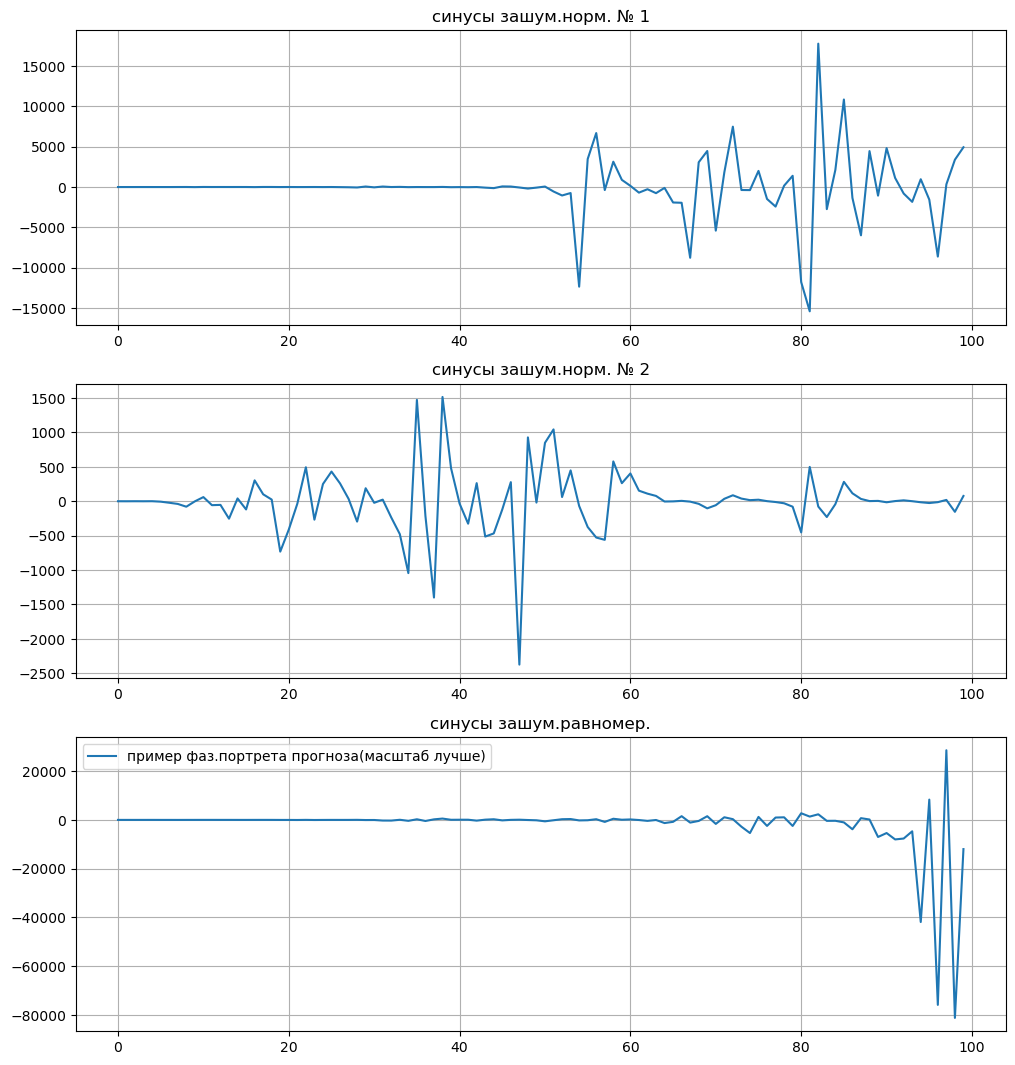

In [47]:
srezka = 100

plt.figure(figsize=[12, 13])

plt.subplot(3, 1, 1)
plt.title('синусы зашум.норм. № 1')
plt.plot(np.arange(srezka), phase_trajectories_X[0][:srezka], label='пример траектории прогноза')
plt.grid()


plt.subplot(3, 1, 2)
plt.title('синусы зашум.норм. № 2')
plt.plot(np.arange(srezka), phase_trajectories_Y[0][:srezka], label='пример траектории прогноза')
plt.grid()


plt.subplot(3, 1, 3)
plt.title('синусы зашум.равномер.')
plt.plot(np.arange(srezka), phase_trajectories_Z[0][:srezka], label='пример фаз.портрета прогноза(масштаб лучше)')
plt.grid()


#phase_tr_orig = diff(not_offset)/dx ну может пригодится - пока не буду убирать
plt.legend()

plt.show()

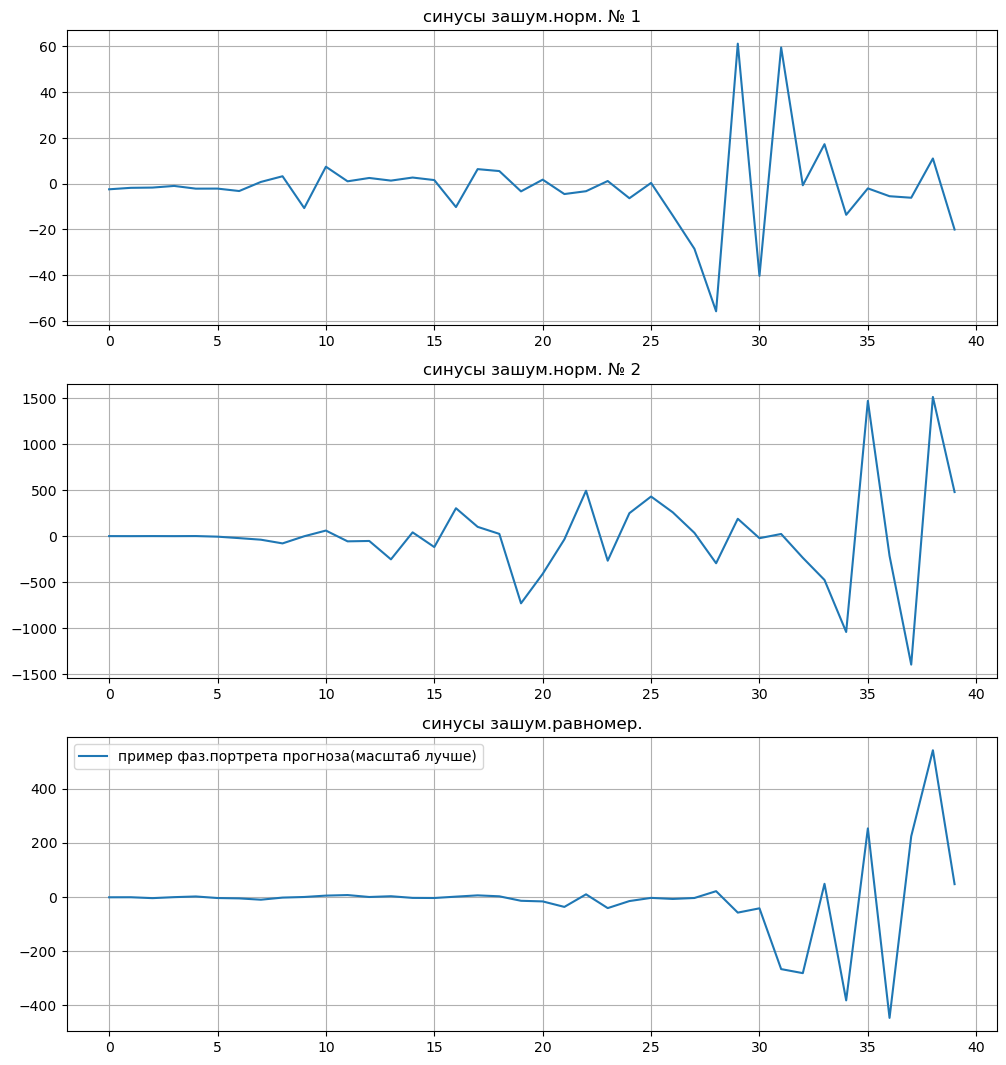

In [48]:
srezka = 40

plt.figure(figsize=[12, 13])

plt.subplot(3, 1, 1)
plt.title('синусы зашум.норм. № 1')
plt.plot(np.arange(srezka), phase_trajectories_X[0][:srezka], label='пример траектории прогноза')
plt.grid()


plt.subplot(3, 1, 2)
plt.title('синусы зашум.норм. № 2')
plt.plot(np.arange(srezka), phase_trajectories_Y[0][:srezka], label='пример траектории прогноза')
plt.grid()


plt.subplot(3, 1, 3)
plt.title('синусы зашум.равномер.')
plt.plot(np.arange(srezka), phase_trajectories_Z[0][:srezka], label='пример фаз.портрета прогноза(масштаб лучше)')
plt.grid()


#phase_tr_orig = diff(not_offset)/dx ну может пригодится - пока не буду убирать
plt.legend()

plt.show()

## Оцениваем их корреляцию??? (здесь метод Сугихары такой, каким я его понял - пока что)

In [80]:
import math
import random
from causal_ccm.causal_ccm import ccm

def pyrson(orig, prognoz):
    return np.sum((orig - np.mean(orig)) * (prognoz - np.mean(prognoz))) / np.linalg.norm(orig - np.mean(orig)) / np.linalg.norm(prognoz - np.mean(prognoz))

def sugihara(A, B):
    N_templ = len(A)
    
    A_hankel = np.array([[A[math.ceil((i + j) / 2)] for i in range(N_templ)] for j in range(N_templ)], dtype=float)
    B_hankel = np.array([[B[math.ceil((i + j) / 2)] for i in range(N_templ)] for j in range(N_templ)], dtype=float)

    cnt_iter = 400
    corr = 0

    for i in range(cnt_iter):
        corr += pyrson(random.choice(A_hankel), random.choice(B_hankel))

    return corr / cnt_iter

def ccm_(A, B):
    tau = 1 
    E = 3
    L = len(A) 
    
    ccm1 = ccm(A, B, tau, E, L)
    
    corr_, p = ccm1.causality()
    return p

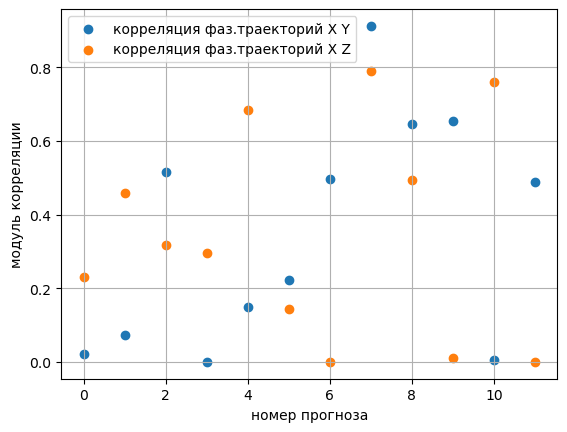

In [81]:
corr_XY = np.array([], dtype=float)
corr_XZ = np.array([], dtype=float)


for i in range(len(forecast_X)):
    #print('Корр. фаз. траект. норм. между собой', pyrson(phase_trajectories_X[i], phase_trajectories_Y[i]))
    #print('и норм. с равном.', pyrson(phase_trajectories_Y[i], phase_trajectories_Z[i]))    
    
    #print('Корр. фаз. траект. норм. между собой', sugihara(phase_trajectories_X[i], phase_trajectories_Y[i]))
    #print('и норм. с равном.', sugihara(phase_trajectories_Y[i], phase_trajectories_Z[i]))

    corr_XY = np.append(corr_XY, np.abs(ccm_(phase_trajectories_X[i], phase_trajectories_Y[i])))
    corr_XZ = np.append(corr_XZ, np.abs(ccm_(phase_trajectories_X[i], phase_trajectories_Z[i])))
    #print('Корр. фаз. траект. норм. между собой', ccm_(phase_trajectories_X[i], phase_trajectories_Y[i]))
    #print('и норм. с равном.', ccm_(phase_trajectories_X[i], phase_trajectories_Z[i]))

plt.scatter(np.arange(len(corr_XY)), corr_XY, label='корреляция фаз.траекторий X Y')
plt.scatter(np.arange(len(corr_XY)), corr_XZ, label='корреляция фаз.траекторий X Z')
plt.xlabel('номер прогноза')
plt.ylabel('модуль корреляции')
plt.legend()
plt.grid()
plt.show()

В 7 случаях из 12 прогноз дал верный результат. А именно то, что первые две выборки коррелируют сильнее, чем первая и третья

Вердикт: Надо продолжать эксперименты